# AIMNet2 tmQM-OpenFF

## Import AIMNet2 tmQM-OpenFF trainings

In [4]:
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

import helper
from helper import extract_config
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy

sns.set_theme()
sns.set_context("notebook")

In [16]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/aimnet2_tmqm_openff",
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 237 runs


In [17]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['seed=42',
  'full_dataset_sm3_v1.1',
  'per_system_energy=0.0001',
  'per_system_dipole_moment=0',
  'per_atom_charge=1',
  '0.1.4+300.gef9c8be.dirty',
  'tmqm_openff_local',
  'AimNet2',
  'loss-per_system_energy',
  'loss-per_system_dipole_moment',
  'loss-per_atom_charge']}

In [18]:
runs[81].summary["val/per_system_energy/mae"]

69.1437759399414

In [24]:
test_results = []

for run in runs:
    if run.state == "finished":
        record = {}
    
        record.update({"name": run.name})
        
        training_parameter = run.config["training_parameter"]
        potential_parameter = run.config['potential_parameter']
        tags = extract_config(training_parameter, "tags")["tags"]

        try:
            record.update({
                "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
                "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
            })
        except KeyError:
            record.update({
                "test/per_system_energy/mae": pd.NA,
                "test/per_system_energy/rmse": pd.NA,
            })
        record.update({
                "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
                "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
                "val/per_system_dipole_moment/mae": run.summary["val/per_system_dipole_moment/mae"],
                "val/per_atom_charge/mae": run.summary["val/per_atom_charge/mae"],
            })
        
        record.update(extract_config(potential_parameter, "number_of_radial_basis_functions"))
        record.update(extract_config(potential_parameter, "number_of_vector_features"))
        record.update(extract_config(potential_parameter, "number_of_per_atom_features"))

        loss_weights = extract_config(training_parameter, "weight")
        record.update(loss_weights["weight"])

        record["dataset_version"] = extract_config(run.config["training_parameter"], "tags")["tags"][1]
        if "spin_multiplicity_embedding" in tags:
            record["spin_embedding"] = True
        else:
            record["spin_embedding"] = False

        record["group"] = run.group
        record.update(
            extract_config(training_parameter, "seed")
        )
        test_results.append(record)

test_results_df = pd.DataFrame(test_results)

In [26]:
test_results_df.sort_values(by="val/per_system_energy/mae").head(50)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
160,"sm_1_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",<NA>,<NA>,47.190578,83.477081,0.149201,0.028612,64,8,128,0.0001,0.0,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
187,"full_dataset_v1.2_[0.0001, 0.1, 0]_(43)",<NA>,<NA>,50.162586,95.537132,0.139438,0.171702,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,43
186,"full_dataset_v1.2_[0.0001, 0, 1]_(43)",<NA>,<NA>,50.529491,92.023438,0.145163,0.029573,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,43
165,"sm_3_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",<NA>,<NA>,50.572193,86.348091,0.146770,0.032781,64,8,128,0.0001,0.0,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42
163,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 0]_(42)",<NA>,<NA>,50.832760,91.653175,0.149640,0.226110,64,8,128,0.0001,0.1,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
210,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 0]_(45)",<NA>,<NA>,51.941250,91.402840,0.148569,0.182785,64,8,128,0.0001,0.1,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,45
161,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(42)",<NA>,<NA>,52.086086,93.028130,0.135807,0.030554,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42
191,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 0]_(44)",<NA>,<NA>,53.612797,90.806915,0.163044,0.127200,64,8,128,0.0001,0.1,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,44
172,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(43)",<NA>,<NA>,53.994968,89.004837,0.134275,0.026568,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,43
167,"sm_5_n_configs_10_v1.2_[0.0001, 0.1, 1]_(42)",<NA>,<NA>,54.602440,88.857330,0.139845,0.036349,64,8,128,0.0001,0.1,1.0,sm_5_n_configs_10_v1.2,True,exp08_3,42


In [23]:
test_results_df.sort_values(by="val/per_system_energy/mae").tail(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/rmse,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
27,"full_dataset_v1.1_[0.0001, 0.1, 1]_(43)",198.279724,244.48671,198.204254,243.808640,0.138270,0.078028,64,8,128,0.0001,0.1,1.0,full_dataset_v1.1,False,full_dataset_v1.1,43
45,"full_dataset_v1.1_[0.0001, 0.1, 0]_(44)",201.558609,248.991776,199.194427,245.501053,0.149927,0.217261,64,8,128,0.0001,0.1,0.0,full_dataset_v1.1,False,full_dataset_v1.1,44
13,"full_dataset_v1.1_[0.0001, 0.1, 0]_(42)",200.58577,247.80278,199.747131,245.435745,0.156226,0.203656,64,8,128,0.0001,0.1,0.0,full_dataset_v1.1,False,full_dataset_v1.1,42
61,"full_dataset_v1.1_[0.0001, 0.1, 0]_(45)",199.091919,246.129425,200.184509,246.119308,0.149511,0.215400,64,8,128,0.0001,0.1,0.0,full_dataset_v1.1,False,full_dataset_v1.1,45
31,"full_dataset_v1.1_[1, 0, 0]_(43)",201.964874,248.470901,201.167221,245.988617,0.223220,0.220821,64,8,128,1.0000,0.0,0.0,full_dataset_v1.1,False,full_dataset_v1.1,43
28,"full_dataset_v1.1_[0.0001, 0, 1]_(43)",201.66301,248.249924,201.186111,246.925644,0.148587,0.083857,64,8,128,0.0001,0.0,1.0,full_dataset_v1.1,False,full_dataset_v1.1,43
62,"full_dataset_v1.1_[1, 0, 0]_(45)",199.885437,246.496948,201.724701,247.184784,0.162503,0.223589,64,8,128,1.0000,0.0,0.0,full_dataset_v1.1,False,full_dataset_v1.1,45
2,"full_dataset_v1.1_[0.0001, 0.1, 1]_(42)",201.654968,248.175201,201.869568,247.962585,0.145438,0.075953,64,8,128,0.0001,0.1,1.0,full_dataset_v1.1,False,full_dataset_v1.1,42
15,"full_dataset_v1.1_[1, 0, 0]_(42)",202.491043,249.176529,201.943283,248.029755,0.164964,0.220959,64,8,128,1.0000,0.0,0.0,full_dataset_v1.1,False,full_dataset_v1.1,42
11,"full_dataset_v1.1_[0.0001, 0, 1]_(42)",202.879288,250.064941,202.888824,248.631668,0.155594,0.082535,64,8,128,0.0001,0.0,1.0,full_dataset_v1.1,False,full_dataset_v1.1,42


## Plotting training results

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

Text(0.5, 1.0, 'Stability of dataset splitting')

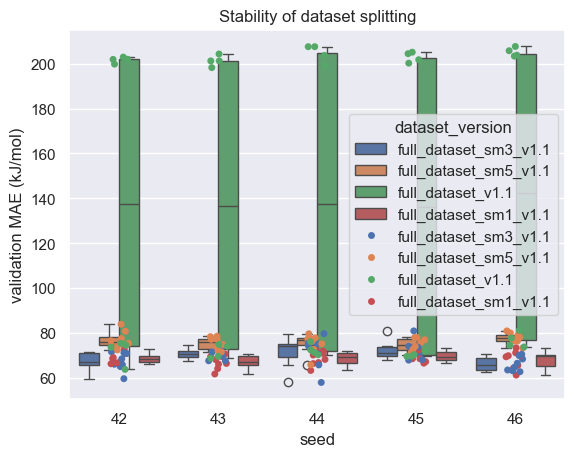

In [21]:
ax = sns.boxplot(
    data=test_results_df,
    x="seed",
    y="val/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=test_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    hue="dataset_version"
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")

### Limit to a single spin multiplicity

In [22]:
results_single_spin = test_results_df[test_results_df["dataset_version"] != "full_dataset_v1.1"]

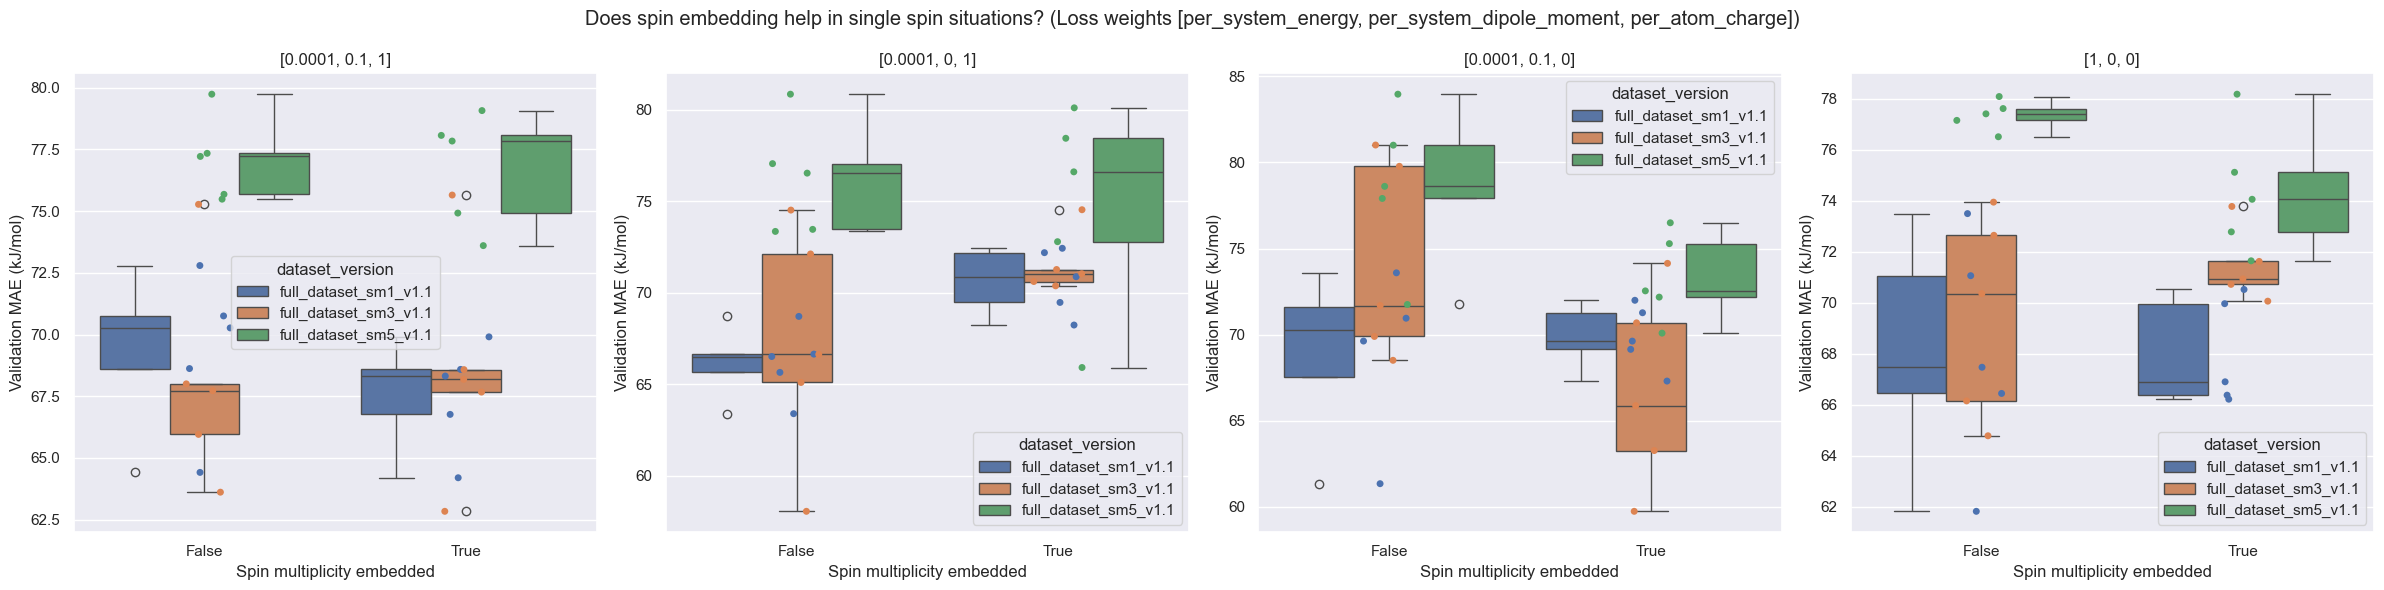

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin embedding help in single spin situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_version_select = [
    "full_dataset_sm1_v1.1",
    "full_dataset_sm3_v1.1",
    "full_dataset_sm5_v1.1",
]

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_single_spin[
        # (results_single_spin["dataset_version"] == options_version_select[i]) &\
        (results_single_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_single_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_single_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
        hue="dataset_version",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        hue="dataset_version",
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### Full dataset comparison

In [26]:
results_multi_spin = test_results_df[test_results_df["dataset_version"] == "full_dataset_v1.1"]

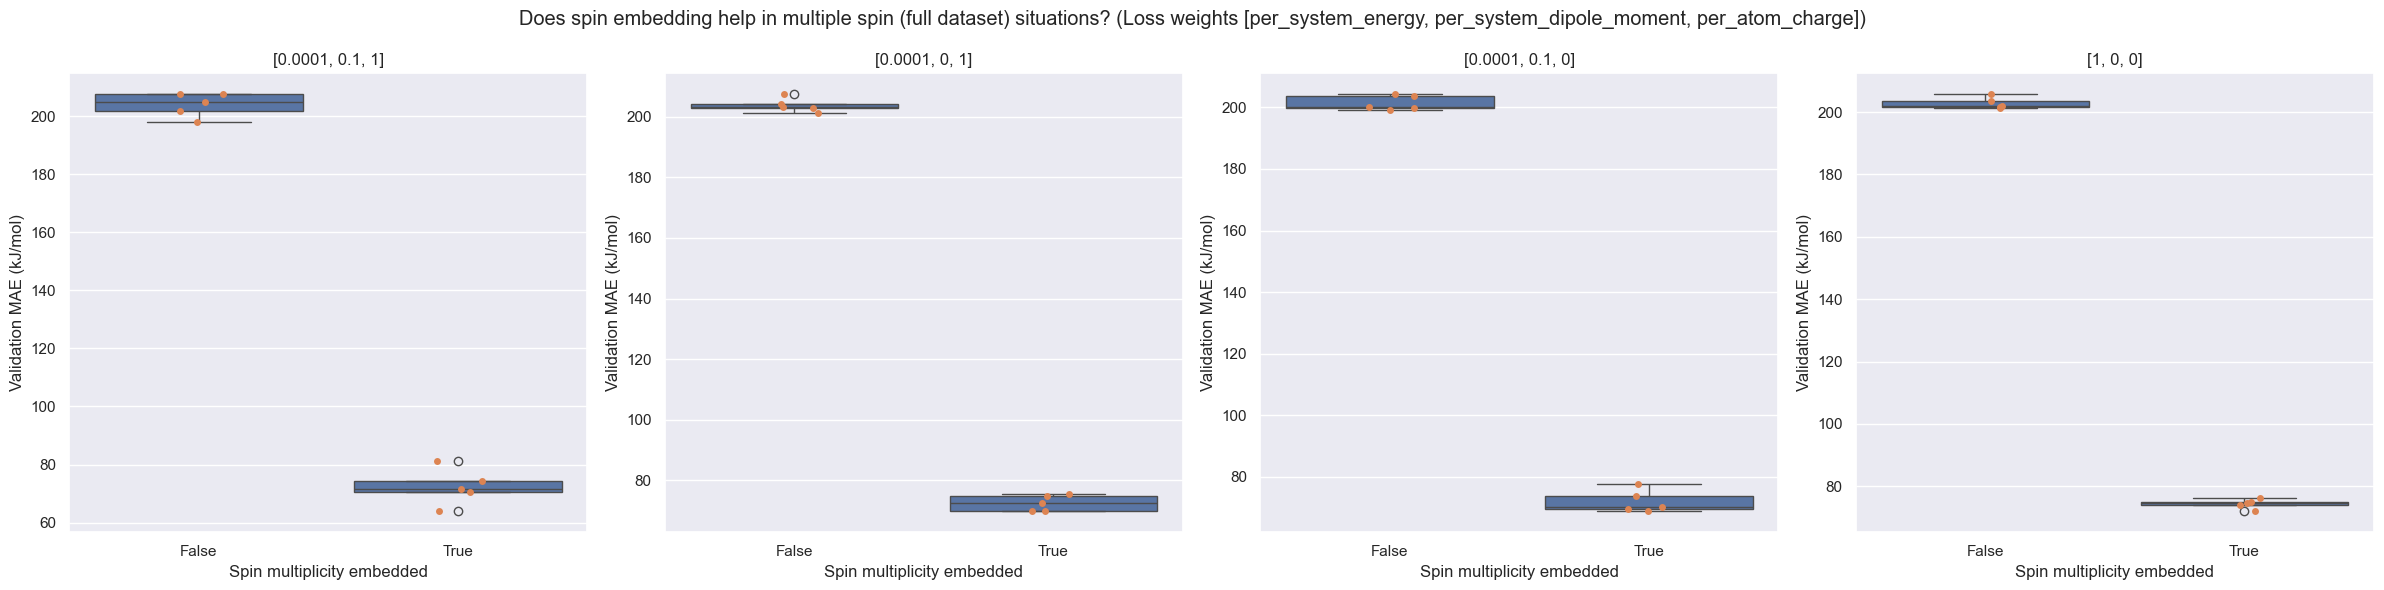

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin embedding help in multiple spin (full dataset) situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

## Plotting datasets

In [17]:
seeds = [42, 43, 44, 45, 46]
seed_results = {
    42: "bad",
    43: "good",
    44: "bad",
    45: "bad",
    46: "good",
}
for i, seed in enumerate(seeds):
    # initialize datasets as in training
    dm = initialize_datamodule(
        dataset_name="tmqm_openff_local",
        version_select="full_dataset_v1.1",
        splitting_strategy=RandomRecordSplittingStrategy(
            seed=seed,
            split=[0.8, 0.1, 0.1],
        ),
        local_cache_dir="../cache",
        dataset_cache_dir="../experiments/exp08/cache/tmqm_openff",
        properties_of_interest=["atomic_numbers", "positions", "dft_total_energy", "scf_dipole", "total_charge", "lowdin_partial_charges", "per_system_spin_multiplicity", "dft_total_force"],
        properties_assignment={
            "atomic_numbers": "atomic_numbers",
            "positions": "positions",
            "E": "dft_total_energy",
            "dipole_moment": "scf_dipole",
            "partial_charges": "lowdin_partial_charges",
            "total_charge": "total_charge",
            "spin_multiplicity":"per_system_spin_multiplicity",
            "F": "dft_total_force",
        },
        local_yaml_file = "../experiments/exp08/cache/tmqm_openff/tmqm_openff_local_mac.yaml" #note, this should in general be the full path to the yaml file,
                                                        #but for testing purposes on CI, we need to use a placeholder
                                                        #i.e., path_to_file, which the test will replace.
    )
    train_dataset, val_dataset, test_dataset = (
            dm.train_dataset,
            dm.val_dataset,
            dm.test_dataset,
        )

    # gather per geometry properties
    gp = helper.PerGeometryProperties(
        seed,
        train_dataset,
        val_dataset,
        test_dataset,
        property_names=[
            "per_system_spin_state",
            "per_system_total_charge",
            "positions",
            "per_atom_force",
            "per_system_dipole_moment",
            "per_system_energy",
        ],
        dataset=dm.torch_dataset,
    )
    gp.prepare()

    # gather per compound properties
    cp = helper.PerCompoundProperties(
        seed,
        train_dataset,
        val_dataset,
        test_dataset,
        property_names=[
            "atomic_numbers",
        ],
        dataset=dm.torch_dataset,
    )
    cp.prepare()
    cp.update("number_of_atoms")

    # concatenate
    if i == 0:
        properties = {
            "per_geometry": gp.dataframe,
            "per_compound": cp.dataframe,
        }
    else:
        properties["per_geometry"] = pd.concat([properties["per_geometry"], gp.dataframe])
        properties["per_compound"] = pd.concat([properties["per_compound"], cp.dataframe])

2025-08-06 22:21:37.932 | DEBUG    | modelforge.dataset.dataset:__init__:330 - Loading config data from user specified file: ../experiments/exp08/cache/tmqm_openff/tmqm_openff_local_mac.yaml
2025-08-06 22:21:37.940 | INFO     | modelforge.dataset.dataset:__init__:359 - Using dataset version full_dataset_v1.1
2025-08-06 22:21:37.941 | DEBUG    | modelforge.dataset.dataset:_acquire_dataset:474 - Using local yaml file for dataset.


{'file_name': '/Users/syan/workdir/modelforge-experiments/experiments/exp08/cache/tmqm_openff/tmqm_openff_dataset_v1.1.hdf5', 'md5': '9a42e2a0a4dbe702fb8607c1705f0d2d'}
Validating file /Users/syan/workdir/modelforge-experiments/experiments/exp08/cache/tmqm_openff/tmqm_openff_dataset_v1.1.hdf5


2025-08-06 22:21:40.099 | DEBUG    | modelforge.dataset.dataset:_from_hdf5:787 - Reading data from /Users/syan/workdir/modelforge-experiments/experiments/exp08/cache/tmqm_openff/tmqm_openff_dataset_v1.1.hdf5
2025-08-06 22:21:40.099 | DEBUG    | modelforge.dataset.dataset:_from_hdf5:788 - element filter: None
2025-08-06 22:21:40.123 | DEBUG    | modelforge.dataset.dataset:_from_hdf5:820 - Properties of Interest: ['atomic_numbers', 'positions', 'dft_total_energy', 'scf_dipole', 'total_charge', 'lowdin_partial_charges', 'per_system_spin_multiplicity', 'dft_total_force']
2025-08-06 22:21:40.123 | DEBUG    | modelforge.dataset.dataset:_from_hdf5:826 - n_entries: 15127
100%|██████████| 15127/15127 [00:38<00:00, 388.43it/s]
2025-08-06 22:22:19.285 | DEBUG    | modelforge.dataset.dataset:_to_file_cache:1038 - Writing npz file to ../cache/tmqm_openff_local.npz
2025-08-06 22:22:19.667 | DEBUG    | modelforge.dataset.dataset:_from_file_cache:999 - Loading processed data from ../cache/tmqm_openff_

Validating file ../cache/tmqm_openff_local.npz


2025-08-06 22:22:19.908 | INFO     | modelforge.dataset.dataset:_calculate_atomic_self_energies:1360 - Using atomic self energies provided by the dataset.
2025-08-06 22:22:19.908 | DEBUG    | modelforge.dataset.dataset:prepare_data:1257 - Process dataset ...
2025-08-06 22:22:19.908 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1434 - Performing per datapoint operations in the dataset dataset
2025-08-06 22:22:19.909 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1436 - Removing self energies from the dataset
Calculating pairlist for dataset: 100%|██████████| 2108/2108 [00:15<00:00, 138.30it/s]
2025-08-06 22:22:41.427 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:167 - Calculating mean and variance of atomic energies
100%|██████████| 824/824 [00:05<00:00, 142.89it/s]
2025-08-06 22:22:47.199 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:179 - Mean and standard deviation of the dataset:{'per_atom_energy_mean': t

Validating file ../cache/tmqm_openff_local.npz


2025-08-06 22:30:02.978 | INFO     | modelforge.dataset.dataset:_calculate_atomic_self_energies:1360 - Using atomic self energies provided by the dataset.
2025-08-06 22:30:02.979 | DEBUG    | modelforge.dataset.dataset:prepare_data:1257 - Process dataset ...
2025-08-06 22:30:02.979 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1434 - Performing per datapoint operations in the dataset dataset
2025-08-06 22:30:02.979 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1436 - Removing self energies from the dataset
Calculating pairlist for dataset: 100%|██████████| 2108/2108 [00:16<00:00, 129.73it/s]
2025-08-06 22:30:25.839 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:167 - Calculating mean and variance of atomic energies
100%|██████████| 824/824 [00:05<00:00, 145.08it/s]
2025-08-06 22:30:31.522 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:179 - Mean and standard deviation of the dataset:{'per_atom_energy_mean': t

Validating file ../cache/tmqm_openff_local.npz


2025-08-06 22:37:19.032 | INFO     | modelforge.dataset.dataset:_calculate_atomic_self_energies:1360 - Using atomic self energies provided by the dataset.
2025-08-06 22:37:19.033 | DEBUG    | modelforge.dataset.dataset:prepare_data:1257 - Process dataset ...
2025-08-06 22:37:19.033 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1434 - Performing per datapoint operations in the dataset dataset
2025-08-06 22:37:19.033 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1436 - Removing self energies from the dataset
Calculating pairlist for dataset: 100%|██████████| 2108/2108 [00:15<00:00, 131.93it/s]
2025-08-06 22:37:41.497 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:167 - Calculating mean and variance of atomic energies
100%|██████████| 824/824 [00:05<00:00, 139.97it/s]
2025-08-06 22:37:47.389 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:179 - Mean and standard deviation of the dataset:{'per_atom_energy_mean': t

Validating file ../cache/tmqm_openff_local.npz


2025-08-06 22:44:32.623 | INFO     | modelforge.dataset.dataset:_calculate_atomic_self_energies:1360 - Using atomic self energies provided by the dataset.
2025-08-06 22:44:32.623 | DEBUG    | modelforge.dataset.dataset:prepare_data:1257 - Process dataset ...
2025-08-06 22:44:32.624 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1434 - Performing per datapoint operations in the dataset dataset
2025-08-06 22:44:32.624 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1436 - Removing self energies from the dataset
Calculating pairlist for dataset: 100%|██████████| 2108/2108 [00:16<00:00, 131.35it/s]
2025-08-06 22:44:54.826 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:167 - Calculating mean and variance of atomic energies
100%|██████████| 824/824 [00:06<00:00, 134.61it/s]
2025-08-06 22:45:00.952 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:179 - Mean and standard deviation of the dataset:{'per_atom_energy_mean': t

Validating file ../cache/tmqm_openff_local.npz


2025-08-06 22:51:54.659 | INFO     | modelforge.dataset.dataset:_calculate_atomic_self_energies:1360 - Using atomic self energies provided by the dataset.
2025-08-06 22:51:54.660 | DEBUG    | modelforge.dataset.dataset:prepare_data:1257 - Process dataset ...
2025-08-06 22:51:54.660 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1434 - Performing per datapoint operations in the dataset dataset
2025-08-06 22:51:54.660 | INFO     | modelforge.dataset.dataset:_per_datapoint_operations:1436 - Removing self energies from the dataset
Calculating pairlist for dataset: 100%|██████████| 2108/2108 [00:15<00:00, 133.11it/s]
2025-08-06 22:52:16.903 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:167 - Calculating mean and variance of atomic energies
100%|██████████| 824/824 [00:06<00:00, 134.38it/s]
2025-08-06 22:52:23.039 | INFO     | modelforge.dataset.utils:calculate_mean_and_variance:179 - Mean and standard deviation of the dataset:{'per_atom_energy_mean': t

In [18]:
gd = properties["per_geometry"]
cd = properties["per_compound"]

In [19]:
properties["per_geometry"]

,dataset_type,seed,per_system_spin_state,per_system_total_charge,positions,per_atom_force,per_system_dipole_moment,per_system_energy
0,training,42,1,0,"[[0.88174295, 0.35297278, 0.4744779], [0.89759...","[[82.7190988011844, -2.08195089093529, -58.355...","[0.011083181269406281, 0.0001047317287277095, ...",-463.578378
1,training,42,3,0,"[[0.88174295, 0.35297278, 0.4744779], [0.89759...","[[128.54889393974935, 4.735778136957394, -37.0...","[0.008833307197572427, -0.004230419654496002, ...",-228.080239
2,training,42,5,0,"[[0.88174295, 0.35297278, 0.4744779], [0.89759...","[[364.6084829078595, 33.46592009782392, 177.88...","[0.012744445705571749, 0.006300893316257598, -...",114.005456
3,training,42,1,0,"[[0.8782753, 0.3503776, 0.47313493], [0.888137...","[[420.5004741093117, 67.1158956607095, -477.44...","[0.00900832888139196, -0.005887720123705858, 0...",-393.534789
4,training,42,3,0,"[[0.8782753, 0.3503776, 0.47313493], [0.888137...","[[420.5167130720578, 58.75964689569006, -425.6...","[0.01067231535545543, -0.004472100188608598, 0...",-154.835614
...,...,...,...,...,...,...,...,...
421545,test,46,3,0,"[[0.2710664, 0.6617136, 1.831874], [0.33203083...","[[-59.63291535458448, -1027.55323735542, 575.9...","[0.13249506257069088, 0.4370720674754758, 1.81...",331.169332
421546,test,46,5,0,"[[0.2710664, 0.6617136, 1.831874], [0.33203083...","[[-831.314435143078, -532.9721030732244, -47.5...","[0.13021377940952542, 0.5058164256640906, 1.81...",636.301227
421547,test,46,1,0,"[[0.2676632, 0.6574101, 1.8372891], [0.3361684...","[[536.5086801439153, -1140.098102147419, 568.6...","[0.20181317136386653, 0.3749728385810599, 1.81...",106.684921
421548,test,46,3,0,"[[0.2676632, 0.6574101, 1.8372891], [0.3361684...","[[433.70276400658605, -1091.158248683887, 510....","[0.1284705936098532, 0.43547121211325396, 1.81...",333.050236


In [20]:
properties["per_compound"]

,dataset_type,seed,atomic_numbers,number_of_atoms
0,training,42,"[6, 1, 6, 1, 6, 6, 6, 1, 6, 1, 6, 1, 6, 6, 6, ...",77
1,training,42,"[46, 17, 17, 15, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6,...",92
2,training,42,"[26, 7, 6, 6, 6, 6, 6, 1, 1, 1, 1, 16, 7, 6, 7...",27
3,training,42,"[46, 16, 16, 15, 15, 7, 7, 7, 7, 7, 6, 1, 6, 1...",60
4,training,42,"[26, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 7, 7, 6,...",41
...,...,...,...,...
15122,test,46,"[46, 15, 15, 17, 17, 6, 1, 1, 6, 1, 1, 6, 1, 1...",70
15123,test,46,"[30, 35, 35, 8, 7, 7, 6, 1, 6, 1, 6, 1, 6, 1, ...",31
15124,test,46,"[6, 1, 1, 6, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, ...",57
15125,test,46,"[6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 1, 1, 6, 1, 1, ...",107


In [22]:
from modelforge.train.training import TrainingAdapter

In [24]:
model = TrainingAdapter.load_from_checkpoint("/Users/syan/workdir/modelforge-experiments/experiments/exp08_2/runs/run079/best_AimNet2-tmqm_openff_local-epoch=18.ckpt")

2025-08-07 09:22:43.083 | DEBUG    | modelforge.potential.potential:setup_potential:690 - potential_seed None
2025-08-07 09:22:43.083 | DEBUG    | modelforge.potential.aimnet2:__init__:64 - Initializing the AimNet2 architecture.
2025-08-07 09:22:43.089 | DEBUG    | modelforge.potential.potential:setup_potential:709 - Only unique pairs: False
2025-08-07 09:22:43.091 | DEBUG    | modelforge.potential.potential:setup_potential:744 - Cutoffs: local_cutoff=0.49999999999999994, vdw_cutoff=0.9999999999999999, electrostatic_cutoff=1.4999999999999998
2025-08-07 09:22:43.092 | WARNING  | modelforge.potential.potential:__init__:331 - JIT compiling the postprocessing module with vdw interactions will not work.
2025-08-07 09:22:43.092 | WARNING  | modelforge.potential.potential:__init__:334 - The tad-DFTD3 packaged used is not compatible with torchscript.
2025-08-07 09:22:43.092 | WARNING  | modelforge.potential.potential:__init__:337 - Disabling JIT compilation by setting jit=False.
2025-08-07 09:

In [25]:
model.eval()

TrainingAdapter(
  (potential): Potential(
    (core_network): AimNet2Core(
      (activation_function): GELU(approximate='none')
      (representation_module): AIMNet2Representation(
        (radial_symmetry_function_module): SchnetRadialBasisFunction(
          (radial_basis_function): GaussianRadialBasisFunctionCore()
        )
        (featurize_input): FeaturizeInput(
          (append_to_embedding_tensor): ModuleList(
            (0): AddPerMoleculeValue()
          )
          (embeddings): ModuleList()
          (atomic_number_embedding): Embedding(101, 128)
          (mixing): DenseWithCustomDist(
            in_features=129, out_features=128, bias=True
            (activation_function): Identity()
          )
        )
        (cutoff_module): CosineAttenuationFunction()
      )
      (interaction_modules): ModuleList(
        (0): AIMNet2InteractionModule(
          (gs_to_fatom): Dense(
            in_features=64, out_features=128, bias=False
            (activation_functio

In [39]:
model(test_dataset[0].nnp_input)

RuntimeError: Index tensor must have the same number of dimensions as self tensor